In [1]:
# Cell 1: Importing Required Libraries

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Adding src directory to path for importing custom modules
sys.path.append('../src')

# Importing custom utility functions
from config import *
from data_utils import retrieve_processed_datasets
from model_utils import (
    initialize_all_models,
    train_single_model,
    evaluate_model_predictions,
    perform_cross_validation,
    extract_feature_importance,
    save_trained_model,
    create_model_comparison_table,
    perform_cv_all_models
)
from evaluation_utils import (
    calculate_all_metrics,
    create_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
    compare_multiple_roc_curves,
    generate_classification_report,
    create_metrics_summary_table
)
from visualization import plot_feature_importance_horizontal

# Setting visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("All libraries imported successfully!")
print(f"Working Directory: {Path.cwd()}")
print(f"Random Seed: {SEED_VALUE}")

All libraries imported successfully!
Working Directory: C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\notebooks
Random Seed: 42


In [2]:
# Cell 2: Loading Processed Data from Notebook 01
# Loading the cleaned and scaled training/test data

print("LOADING PROCESSED DATA...")

# Loading processed datasets using utility function
X_train, X_test, y_train, y_test = retrieve_processed_datasets(file_prefix='higgs')

print("\nData loaded successfully!")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Verifying class distribution
print("\nClass Distribution in Training Set:")
train_dist = y_train.value_counts()
for class_label, count in train_dist.items():
    percentage = (count / len(y_train)) * 100
    print(f"  Class {int(class_label)}: {count:,} samples ({percentage:.2f}%)")

print("\nClass Distribution in Test Set:")
test_dist = y_test.value_counts()
for class_label, count in test_dist.items():
    percentage = (count / len(y_test)) * 100
    print(f"  Class {int(class_label)}: {count:,} samples ({percentage:.2f}%)")

# Calculating imbalance ratio
minority_count = train_dist.min()
majority_count = train_dist.max()
imbalance_ratio = minority_count / majority_count
print(f"\nImbalance Ratio: {imbalance_ratio:.3f}:1")


LOADING PROCESSED DATA...
Loading processed data from C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\data\processed...
Datasets loaded successfully
Training shape: (800000, 28)
Testing shape: (200000, 28)

Data loaded successfully!
Training set shape: (800000, 28)
Test set shape: (200000, 28)

Class Distribution in Training Set:
  Class 1: 423,738 samples (52.97%)
  Class 0: 376,262 samples (47.03%)

Class Distribution in Test Set:
  Class 1: 105,935 samples (52.97%)
  Class 0: 94,065 samples (47.03%)

Imbalance Ratio: 0.888:1


In [3]:
# Cell 3: Initializing All Baseline Models
# Creating instances of all 5 sklearn models WITHOUT class weights
# Models: Logistic Regression, Random Forest, XGBoost, SVM, MLP
# I am using original imbalanced data to establish baseline performance

print("INITIALIZING BASELINE MODELS...")

# Initializing all models without class weights (true baseline)
baseline_models = initialize_all_models(use_class_weights=False)

print(f"\nInitialized {len(baseline_models)} models:")
for i, (model_name, model) in enumerate(baseline_models.items(), 1):
    print(f"  {i}. {model_name}: {type(model).__name__}")

print("\nModel Configurations:")
print("\n1. Logistic Regression:")
print(f"   - Max iterations: {LOGIT_CONFIG['max_iter']}")
print(f"   - Solver: {LOGIT_CONFIG['solver']}")

print("\n2. Random Forest:")
print(f"   - N estimators: {RF_CONFIG['n_estimators']}")
print(f"   - Max depth: {RF_CONFIG['max_depth']}")

print("\n3. XGBoost:")
print(f"   - N estimators: {XGB_CONFIG['n_estimators']}")
print(f"   - Learning rate: {XGB_CONFIG['learning_rate']}")

print("\n4. Support Vector Machine:")
print(f"   - Kernel: {SVM_CONFIG['kernel']}")
print(f"   - Probability: {SVM_CONFIG['probability']}")

print("\n5. Multi-Layer Perceptron:")
print(f"   - Hidden layers: {MLP_CONFIG['hidden_layer_sizes']}")
print(f"   - Activation: {MLP_CONFIG['activation']}")

print("\nAll models ready for training on original imbalanced data!")

INITIALIZING BASELINE MODELS...

Initialized 5 models:
  1. logistic_regression: LogisticRegression
  2. random_forest: RandomForestClassifier
  3. xgboost: XGBClassifier
  4. svm: SVC
  5. mlp: MLPClassifier

Model Configurations:

1. Logistic Regression:
   - Max iterations: 1000
   - Solver: lbfgs

2. Random Forest:
   - N estimators: 100
   - Max depth: 20

3. XGBoost:
   - N estimators: 100
   - Learning rate: 0.1

4. Support Vector Machine:
   - Kernel: rbf
   - Probability: True

5. Multi-Layer Perceptron:
   - Hidden layers: (100, 50)
   - Activation: relu

All models ready for training on original imbalanced data!


In [4]:
# Cell 4: Training Logistic Regression (Baseline)
# Training linear model as simplest baseline

print("MODEL 1/5: LOGISTIC REGRESSION:")

# Training logistic regression
lr_model, lr_train_time = train_single_model(
    model=baseline_models['logistic_regression'],
    X_train=X_train,
    y_train=y_train,
    model_name='Logistic Regression',
    verbose=True
)

# Evaluating on test set
lr_results = evaluate_model_predictions(
    model=lr_model,
    X_test=X_test,
    y_test=y_test,
    model_name='Logistic Regression',
    verbose=True
)

# Calculating comprehensive metrics
lr_metrics = calculate_all_metrics(
    y_true=y_test,
    y_pred=lr_results['y_pred'],
    y_proba=lr_results['y_proba']
)

print("\nLogistic Regression Performance:")
print(f"  Accuracy: {lr_metrics['accuracy']:.4f}")
print(f"  Precision: {lr_metrics['precision']:.4f}")
print(f"  Recall: {lr_metrics['recall']:.4f}")
print(f"  F1-Score: {lr_metrics['f1_score']:.4f}")
print(f"  AUC-ROC: {lr_metrics['auc_roc']:.4f}")
print(f"  AUC-PR: {lr_metrics['auc_pr']:.4f}")
print(f"  G-Mean: {lr_metrics['g_mean']:.4f}")
print(f"  MCC: {lr_metrics['mcc']:.4f}")

# Storing results for comparison
baseline_results = {
    'logistic_regression': {
        'model': lr_model,
        'metrics': lr_metrics,
        'predictions': lr_results['y_pred'],
        'probabilities': lr_results['y_proba'],
        'training_time': lr_train_time
    }
}

MODEL 1/5: LOGISTIC REGRESSION:
Training Logistic Regression...
Training completed in 3.34 seconds
Evaluating Logistic Regression...
Prediction completed in 0.0286 seconds

Logistic Regression Performance:
  Accuracy: 0.6414
  Precision: 0.6390
  Recall: 0.7425
  F1-Score: 0.6869
  AUC-ROC: 0.6850
  AUC-PR: 0.6832
  G-Mean: 0.6259
  MCC: 0.2771


In [5]:
# Cell 5: Training Random Forest (Baseline)
# Training ensemble tree-based model
# Good performance is expected because it naturally handles imbalance better

print("MODEL 2/5: RANDOM FOREST")

# Training random forest
rf_model, rf_train_time = train_single_model(
    model=baseline_models['random_forest'],
    X_train=X_train,
    y_train=y_train,
    model_name='Random Forest',
    verbose=True
)

# Evaluating on test set
rf_results = evaluate_model_predictions(
    model=rf_model,
    X_test=X_test,
    y_test=y_test,
    model_name='Random Forest',
    verbose=True
)

# Calculating comprehensive metrics
rf_metrics = calculate_all_metrics(
    y_true=y_test,
    y_pred=rf_results['y_pred'],
    y_proba=rf_results['y_proba']
)

print("\nRandom Forest Performance:")
print(f"  Accuracy: {rf_metrics['accuracy']:.4f}")
print(f"  Precision: {rf_metrics['precision']:.4f}")
print(f"  Recall: {rf_metrics['recall']:.4f}")
print(f"  F1-Score: {rf_metrics['f1_score']:.4f}")
print(f"  AUC-ROC: {rf_metrics['auc_roc']:.4f}")
print(f"  AUC-PR: {rf_metrics['auc_pr']:.4f}")
print(f"  G-Mean: {rf_metrics['g_mean']:.4f}")
print(f"  MCC: {rf_metrics['mcc']:.4f}")

# Storing results
baseline_results['random_forest'] = {
    'model': rf_model,
    'metrics': rf_metrics,
    'predictions': rf_results['y_pred'],
    'probabilities': rf_results['y_proba'],
    'training_time': rf_train_time
}

MODEL 2/5: RANDOM FOREST
Training Random Forest...
Training completed in 72.45 seconds
Evaluating Random Forest...
Prediction completed in 1.8143 seconds

Random Forest Performance:
  Accuracy: 0.7318
  Precision: 0.7420
  Recall: 0.7568
  F1-Score: 0.7493
  AUC-ROC: 0.8130
  AUC-PR: 0.8286
  G-Mean: 0.7297
  MCC: 0.4611


In [6]:
# Cell 6: Training XGBoost (Baseline)
# Training gradient boosting model
# It is often the best performer and handles imbalance reasonably but has slower training

print("MODEL 3/5: XGBOOST")

# Training XGBoost
xgb_model, xgb_train_time = train_single_model(
    model=baseline_models['xgboost'],
    X_train=X_train,
    y_train=y_train,
    model_name='XGBoost',
    verbose=True
)

# Evaluating on test set
xgb_results = evaluate_model_predictions(
    model=xgb_model,
    X_test=X_test,
    y_test=y_test,
    model_name='XGBoost',
    verbose=True
)

# Calculating comprehensive metrics
xgb_metrics = calculate_all_metrics(
    y_true=y_test,
    y_pred=xgb_results['y_pred'],
    y_proba=xgb_results['y_proba']
)

print("\nXGBoost Performance:")
print(f"  Accuracy: {xgb_metrics['accuracy']:.4f}")
print(f"  Precision: {xgb_metrics['precision']:.4f}")
print(f"  Recall: {xgb_metrics['recall']:.4f}")
print(f"  F1-Score: {xgb_metrics['f1_score']:.4f}")
print(f"  AUC-ROC: {xgb_metrics['auc_roc']:.4f}")
print(f"  AUC-PR: {xgb_metrics['auc_pr']:.4f}")
print(f"  G-Mean: {xgb_metrics['g_mean']:.4f}")
print(f"  MCC: {xgb_metrics['mcc']:.4f}")

# Storing results
baseline_results['xgboost'] = {
    'model': xgb_model,
    'metrics': xgb_metrics,
    'predictions': xgb_results['y_pred'],
    'probabilities': xgb_results['y_proba'],
    'training_time': xgb_train_time
}

MODEL 3/5: XGBOOST
Training XGBoost...
Training completed in 4.33 seconds
Evaluating XGBoost...
Prediction completed in 0.0820 seconds

XGBoost Performance:
  Accuracy: 0.7303
  Precision: 0.7428
  Recall: 0.7509
  F1-Score: 0.7468
  AUC-ROC: 0.8109
  AUC-PR: 0.8264
  G-Mean: 0.7287
  MCC: 0.4584


In [7]:
# Cell 7: Training Support Vector Machine (Baseline)
# Training kernel-based classifier

print("MODEL 4/5: SUPPORT VECTOR MACHINE")

# Training SVM
svm_model, svm_train_time = train_single_model(
    model=baseline_models['svm'],
    X_train=X_train,
    y_train=y_train,
    model_name='SVM',
    verbose=True
)

# Evaluating on test set
svm_results = evaluate_model_predictions(
    model=svm_model,
    X_test=X_test,
    y_test=y_test,
    model_name='SVM',
    verbose=True
)

# Calculating comprehensive metrics
svm_metrics = calculate_all_metrics(
    y_true=y_test,
    y_pred=svm_results['y_pred'],
    y_proba=svm_results['y_proba']
)

print("\nSVM Performance:")
print(f"  Accuracy: {svm_metrics['accuracy']:.4f}")
print(f"  Precision: {svm_metrics['precision']:.4f}")
print(f"  Recall: {svm_metrics['recall']:.4f}")
print(f"  F1-Score: {svm_metrics['f1_score']:.4f}")
print(f"  AUC-ROC: {svm_metrics['auc_roc']:.4f}")
print(f"  AUC-PR: {svm_metrics['auc_pr']:.4f}")
print(f"  G-Mean: {svm_metrics['g_mean']:.4f}")
print(f"  MCC: {svm_metrics['mcc']:.4f}")

# Storing results
baseline_results['svm'] = {
    'model': svm_model,
    'metrics': svm_metrics,
    'predictions': svm_results['y_pred'],
    'probabilities': svm_results['y_proba'],
    'training_time': svm_train_time
}

MODEL 4/5: SUPPORT VECTOR MACHINE
Training SVM...
Training completed in 1254.29 seconds
Evaluating SVM...
Prediction completed in 50.6166 seconds

SVM Performance:
  Accuracy: 0.5343
  Precision: 0.6010
  Recall: 0.3596
  F1-Score: 0.4500
  AUC-ROC: 0.5767
  AUC-PR: 0.5906
  G-Mean: 0.5127
  MCC: 0.0973


In [8]:
# Cell 8: Training Multi-Layer Perceptron (Baseline)
# Training neural network with sklearn

print("MODEL 5/5: MULTI-LAYER PERCEPTRON")

# Training MLP
mlp_model, mlp_train_time = train_single_model(
    model=baseline_models['mlp'],
    X_train=X_train,
    y_train=y_train,
    model_name='MLP',
    verbose=True
)

# Evaluating on test set
mlp_results = evaluate_model_predictions(
    model=mlp_model,
    X_test=X_test,
    y_test=y_test,
    model_name='MLP',
    verbose=True
)

# Calculating comprehensive metrics
mlp_metrics = calculate_all_metrics(
    y_true=y_test,
    y_pred=mlp_results['y_pred'],
    y_proba=mlp_results['y_proba']
)

print("\nMLP Performance:")
print(f"  Accuracy: {mlp_metrics['accuracy']:.4f}")
print(f"  Precision: {mlp_metrics['precision']:.4f}")
print(f"  Recall: {mlp_metrics['recall']:.4f}")
print(f"  F1-Score: {mlp_metrics['f1_score']:.4f}")
print(f"  AUC-ROC: {mlp_metrics['auc_roc']:.4f}")
print(f"  AUC-PR: {mlp_metrics['auc_pr']:.4f}")
print(f"  G-Mean: {mlp_metrics['g_mean']:.4f}")
print(f"  MCC: {mlp_metrics['mcc']:.4f}")

# Storing results
baseline_results['mlp'] = {
    'model': mlp_model,
    'metrics': mlp_metrics,
    'predictions': mlp_results['y_pred'],
    'probabilities': mlp_results['y_proba'],
    'training_time': mlp_train_time
}

print("ALL 5 BASELINE MODELS TRAINED SUCCESSFULLY")

MODEL 5/5: MULTI-LAYER PERCEPTRON
Training MLP...
Training completed in 301.27 seconds
Evaluating MLP...
Prediction completed in 0.4166 seconds

MLP Performance:
  Accuracy: 0.7546
  Precision: 0.7644
  Recall: 0.7758
  F1-Score: 0.7701
  AUC-ROC: 0.8378
  AUC-PR: 0.8506
  G-Mean: 0.7529
  MCC: 0.5070
ALL 5 BASELINE MODELS TRAINED SUCCESSFULLY


Generating confusion matrices for all models...

Confusion Matrix: Logistic Regression
Confusion matrix saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\baseline_cm_logistic_regression.png


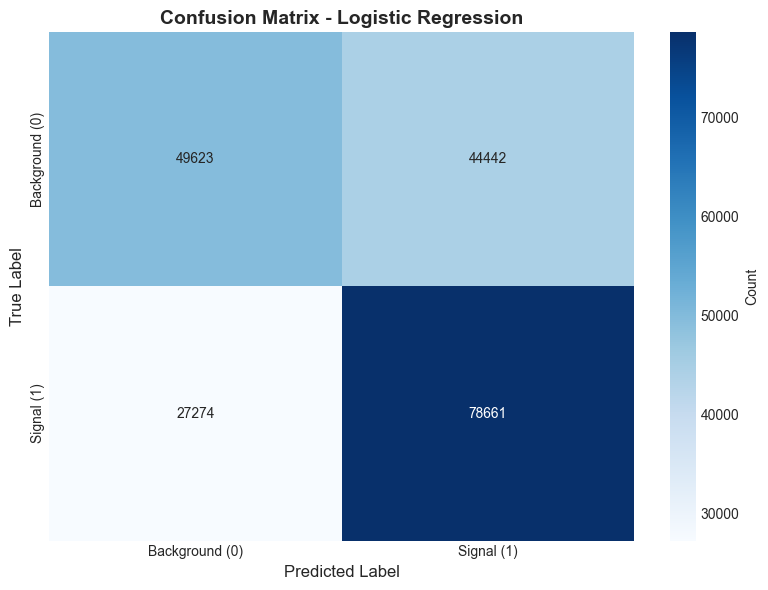

  True Negatives: 49,623
  False Positives: 44,442
  False Negatives: 27,274
  True Positives: 78,661

Confusion Matrix: Random Forest
Confusion matrix saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\baseline_cm_random_forest.png


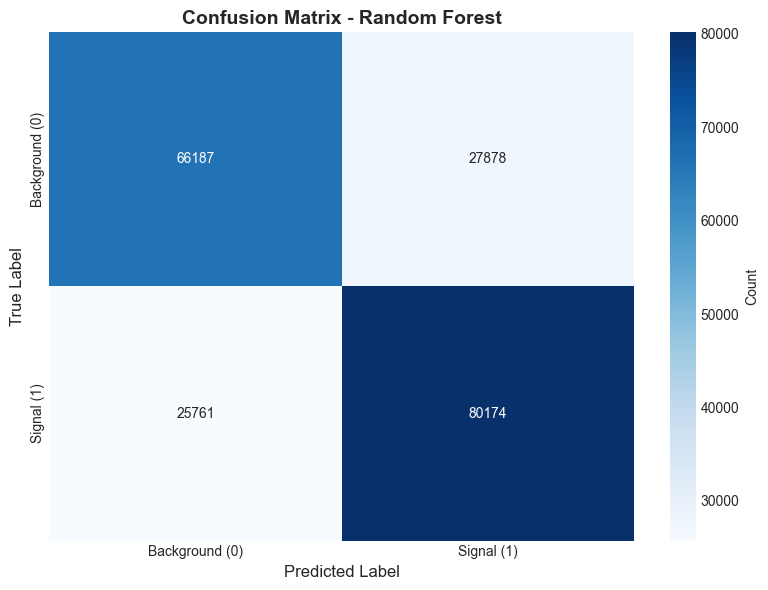

  True Negatives: 66,187
  False Positives: 27,878
  False Negatives: 25,761
  True Positives: 80,174

Confusion Matrix: Xgboost
Confusion matrix saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\baseline_cm_xgboost.png


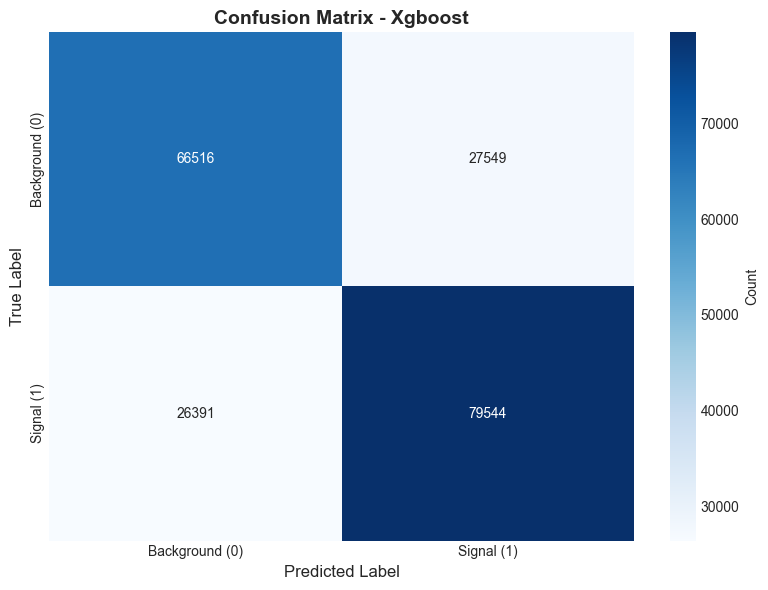

  True Negatives: 66,516
  False Positives: 27,549
  False Negatives: 26,391
  True Positives: 79,544

Confusion Matrix: Svm
Confusion matrix saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\baseline_cm_svm.png


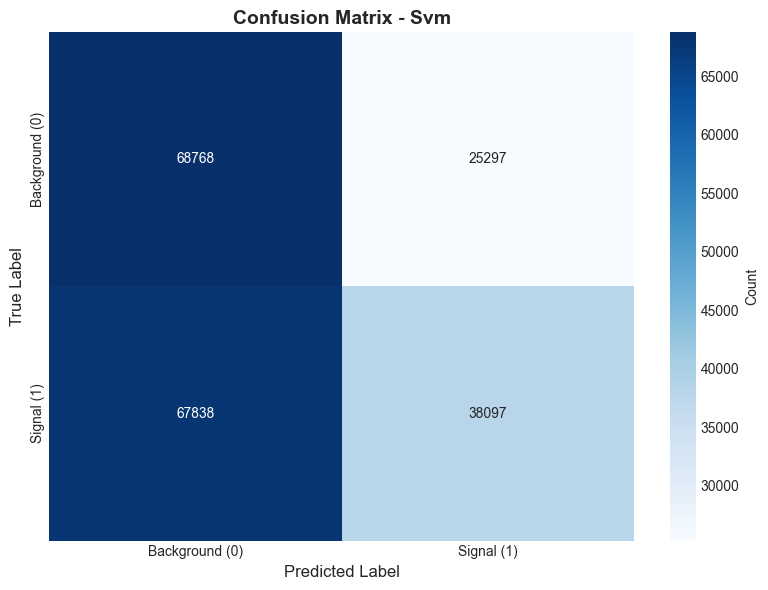

  True Negatives: 68,768
  False Positives: 25,297
  False Negatives: 67,838
  True Positives: 38,097

Confusion Matrix: Mlp
Confusion matrix saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\baseline_cm_mlp.png


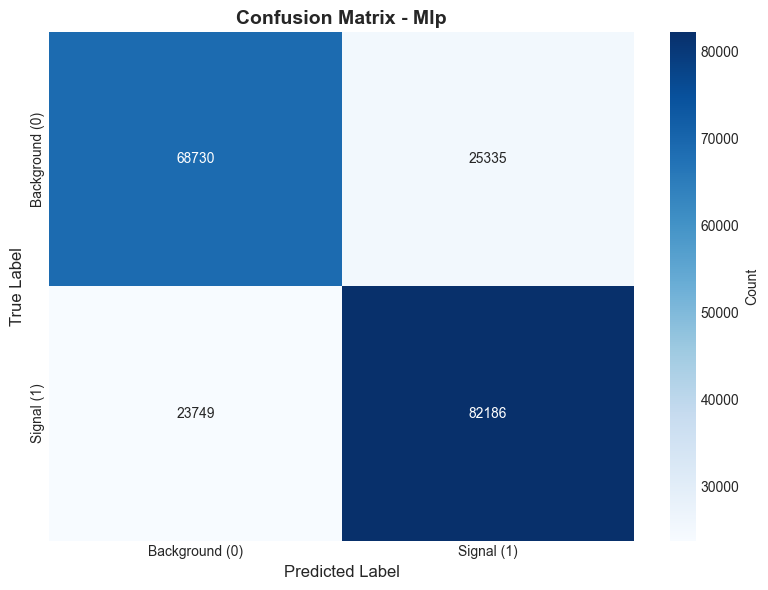

  True Negatives: 68,730
  False Positives: 25,335
  False Negatives: 23,749
  True Positives: 82,186

All confusion matrices created and saved!


In [9]:
# Cell 9: Creating Confusion Matrices for All Models
# Visualizing classification errors for each model

print("Generating confusion matrices for all models...")

# Creating confusion matrix for each model
for model_name, results in baseline_results.items():
    print(f"\nConfusion Matrix: {model_name.replace('_', ' ').title()}")
    
    cm = create_confusion_matrix(
        y_true=y_test,
        y_pred=results['predictions'],
        class_names=['Background (0)', 'Signal (1)'],
        normalize=False,
        save_path=FIGURE_OUTPUT / f'baseline_cm_{model_name}.png',
        title=f'Confusion Matrix - {model_name.replace("_", " ").title()}'
    )
    
    # Printing confusion matrix metrics
    tn, fp, fn, tp = cm.ravel()
    print(f"  True Negatives: {tn:,}")
    print(f"  False Positives: {fp:,}")
    print(f"  False Negatives: {fn:,}")
    print(f"  True Positives: {tp:,}")

print("\nAll confusion matrices created and saved!")

In [11]:
# Cell 10: Performing Cross-Validation on All Models
# Assessing model stability and checking for overfitting

print("CROSS-VALIDATION ANALYSIS")
print(f"Performing {FOLD_COUNT}-fold stratified cross-validation...")

# Combining training and test data for CV (as done in real experiments)
X_full = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
y_full = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

# Defining metrics to evaluate
cv_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Performing CV on all models
cv_results_all = perform_cv_all_models(
    X=X_full,
    y=y_full,
    cv_folds=FOLD_COUNT,
    scoring_metrics=cv_metrics,
    use_class_weights=False,
    verbose=True
)

print("CROSS-VALIDATION COMPLETED")

# Storing CV results
for model_name in baseline_results.keys():
    baseline_results[model_name]['cv_results'] = cv_results_all[model_name]


CROSS-VALIDATION ANALYSIS
Performing 5-fold stratified cross-validation...

Cross-validating: logistic_regression
Performing 5-fold cross-validation for logistic_regression...
Cross-validation completed in 9.00 seconds
Results across 5 folds:
  accuracy: 0.6413 (+/- 0.0006)
  precision: 0.6387 (+/- 0.0007)
  recall: 0.7430 (+/- 0.0010)
  f1: 0.6869 (+/- 0.0004)
  roc_auc: 0.6837 (+/- 0.0010)

Cross-validating: random_forest
Performing 5-fold cross-validation for random_forest...
Cross-validation completed in 509.88 seconds
Results across 5 folds:
  accuracy: 0.7331 (+/- 0.0012)
  precision: 0.7431 (+/- 0.0009)
  recall: 0.7584 (+/- 0.0017)
  f1: 0.7506 (+/- 0.0012)
  roc_auc: 0.8136 (+/- 0.0013)

Cross-validating: xgboost
Performing 5-fold cross-validation for xgboost...
Cross-validation completed in 30.42 seconds
Results across 5 folds:
  accuracy: 0.7315 (+/- 0.0010)
  precision: 0.7435 (+/- 0.0011)
  recall: 0.7527 (+/- 0.0012)
  f1: 0.7481 (+/- 0.0009)
  roc_auc: 0.8112 (+/- 0.0011

Generating ROC curves comparison...
ROC comparison saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\baseline_roc_comparison.png


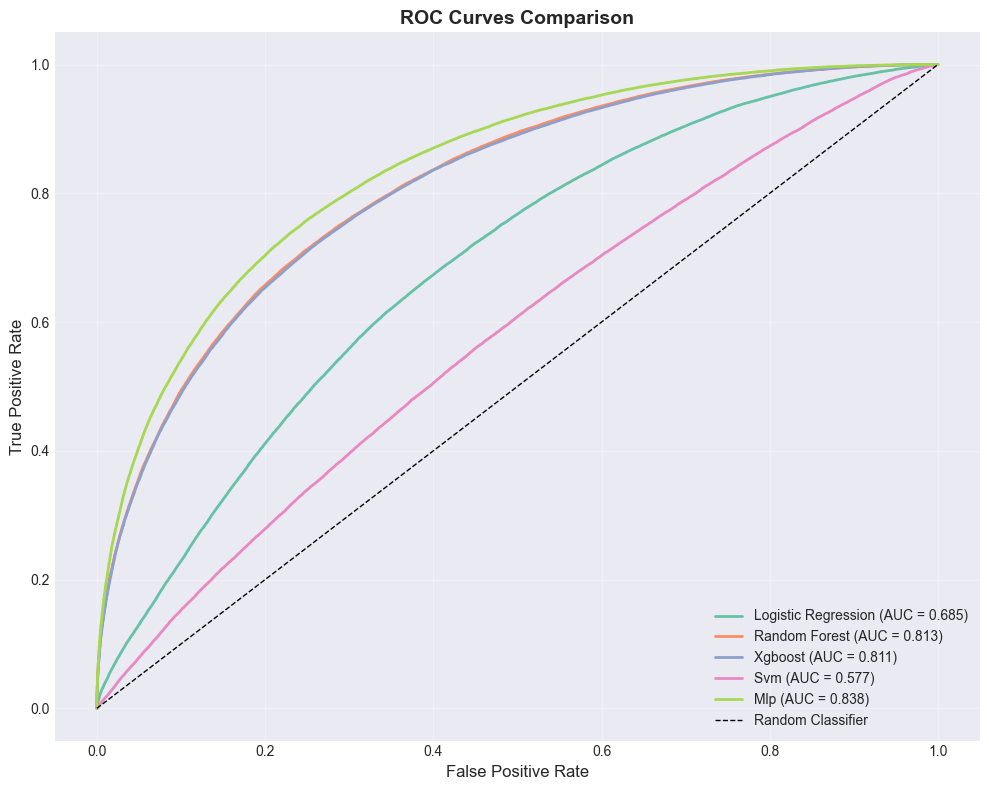


AUC-ROC Scores:
  Mlp: 0.8378
  Random Forest: 0.8130
  Xgboost: 0.8109
  Logistic Regression: 0.6850
  Svm: 0.5767

ROC curves saved


In [13]:
# Cell 11: Comparing ROC Curves for All Models
# Visualizing discrimination ability across models

print("Generating ROC curves comparison...")

# Preparing data for ROC comparison
roc_data = {}
for model_name, results in baseline_results.items():
    roc_data[model_name.replace('_', ' ').title()] = (
        y_test,
        results['probabilities']
    )

# Creating comparison plot
auc_scores = compare_multiple_roc_curves(
    results_dict=roc_data,
    save_path=FIGURE_OUTPUT / 'baseline_roc_comparison.png'
)

print("\nAUC-ROC Scores:")
for model_name, auc_score in sorted(auc_scores.items(), 
                                     key=lambda x: x[1], 
                                     reverse=True):
    print(f"  {model_name}: {auc_score:.4f}")

print("\nROC curves saved")

Generating Precision-Recall curves for all models...
Precision-Recall curves saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\baseline_pr_comparison.png


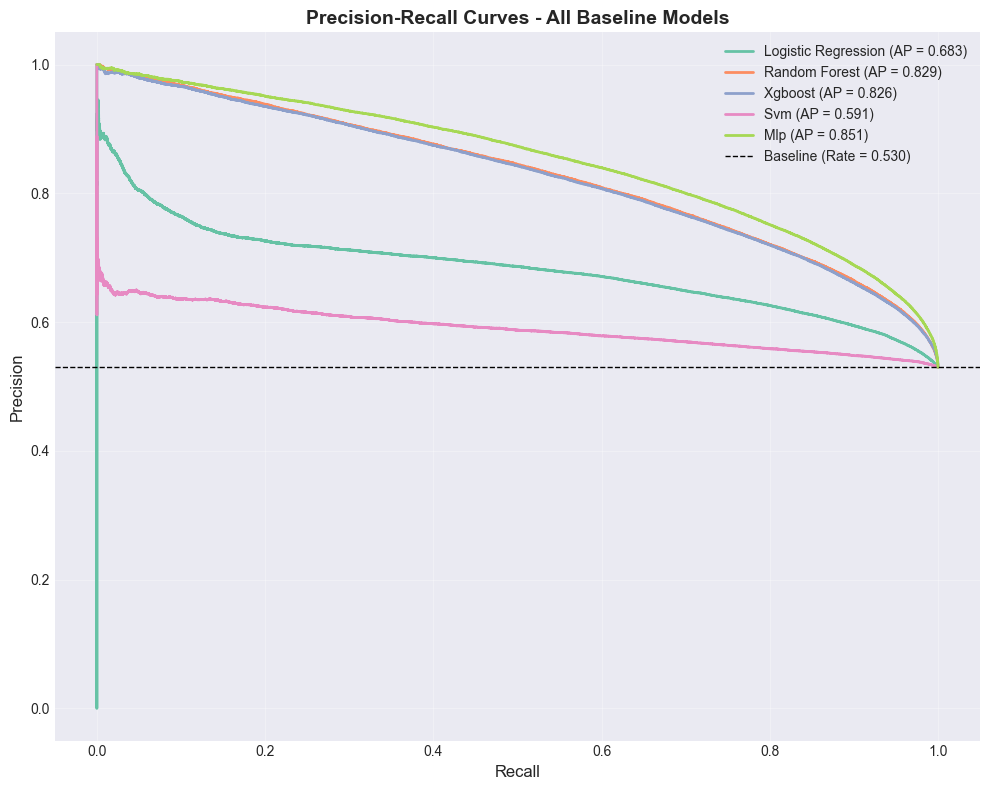


Average Precision Scores:
  Mlp: 0.8506
  Random Forest: 0.8286
  Xgboost: 0.8264
  Logistic Regression: 0.6832
  Svm: 0.5906


In [14]:
# Cell 12: Comparing Precision-Recall Curves
# Better metric for imbalanced data than ROC

print("Generating Precision-Recall curves for all models...")

# Creating figure for PR curves
plt.figure(figsize=(10, 8))

# Plotting PR curve for each model
pr_scores = {}
for model_name, results in baseline_results.items():
    display_name = model_name.replace('_', ' ').title()
    
    # Calculating PR curve
    from sklearn.metrics import precision_recall_curve, average_precision_score
    precision, recall, _ = precision_recall_curve(y_test, results['probabilities'])
    avg_precision = average_precision_score(y_test, results['probabilities'])
    pr_scores[display_name] = avg_precision
    
    # Plotting
    plt.plot(recall, precision, linewidth=2, 
             label=f'{display_name} (AP = {avg_precision:.3f})')

# Adding baseline
baseline_rate = y_test.sum() / len(y_test)
plt.axhline(y=baseline_rate, color='k', linestyle='--', linewidth=1,
            label=f'Baseline (Rate = {baseline_rate:.3f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - All Baseline Models', 
          fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Saving figure
pr_path = FIGURE_OUTPUT / 'baseline_pr_comparison.png'
plt.savefig(pr_path, dpi=DPI_VALUE, bbox_inches='tight')
print(f"Precision-Recall curves saved to {pr_path}")

plt.show()

print("\nAverage Precision Scores:")
for model_name, ap_score in sorted(pr_scores.items(), 
                                    key=lambda x: x[1], 
                                    reverse=True):
    print(f"  {model_name}: {ap_score:.4f}")

FEATURE IMPORTANCE ANALYSIS

Random Forest Feature Importance:
                     feature  importance
25                      m_bb      0.1646
27                    m_wwbb      0.0882
26                     m_wbb      0.0810
22                     m_jjj      0.0665
24                     m_jlv      0.0618
5                   jet_1_pt      0.0604
0                  lepton_pT      0.0434
21                      m_jj      0.0388
3   missing_energy_magnitude      0.0383
9                   jet_2_pt      0.0378
13                  jet_3_pt      0.0280
17                  jet_4_pt      0.0258
23                      m_lv      0.0248
6                  jet_1_eta      0.0217
1                 lepton_eta      0.0210
Feature importance plot saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\baseline_rf_feature_importance.png


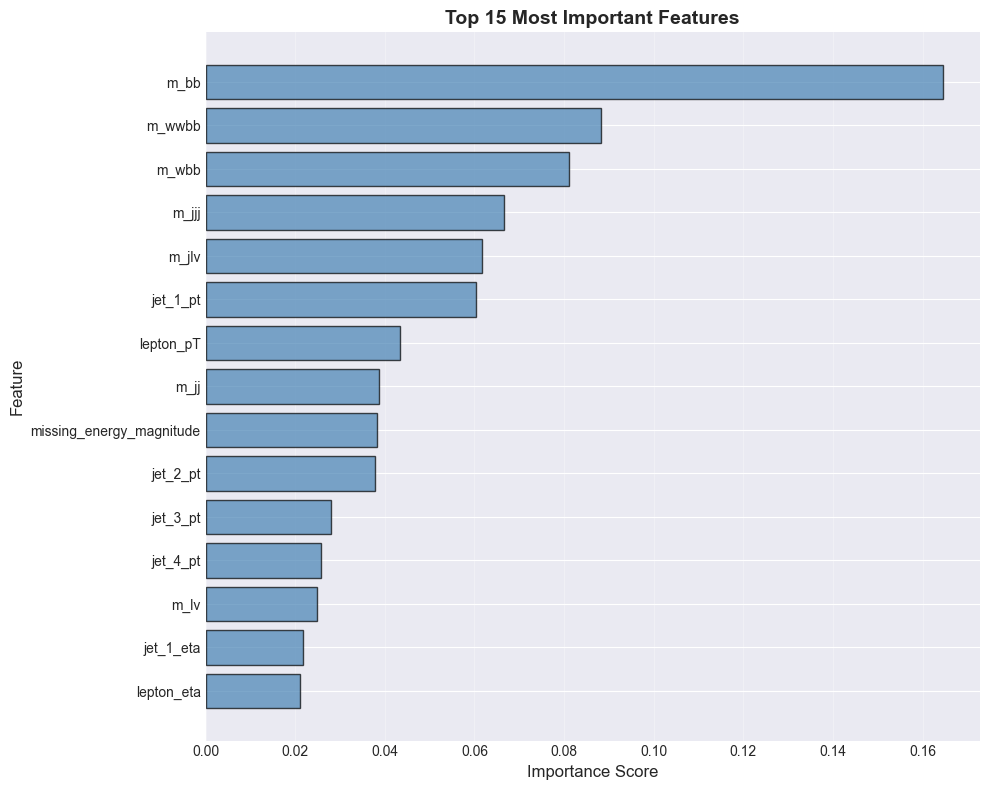

XGBoost Feature Importance:
                     feature  importance
25                      m_bb      0.1976
26                     m_wbb      0.1063
27                    m_wwbb      0.0980
22                     m_jjj      0.0909
24                     m_jlv      0.0730
5                   jet_1_pt      0.0730
3   missing_energy_magnitude      0.0408
8                jet_1_b_tag      0.0385
21                      m_jj      0.0367
0                  lepton_pT      0.0357
9                   jet_2_pt      0.0319
20               jet_4_b_tag      0.0236
23                      m_lv      0.0230
16               jet_3_b_tag      0.0221
13                  jet_3_pt      0.0193
Feature importance plot saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\baseline_xgb_feature_importance.png


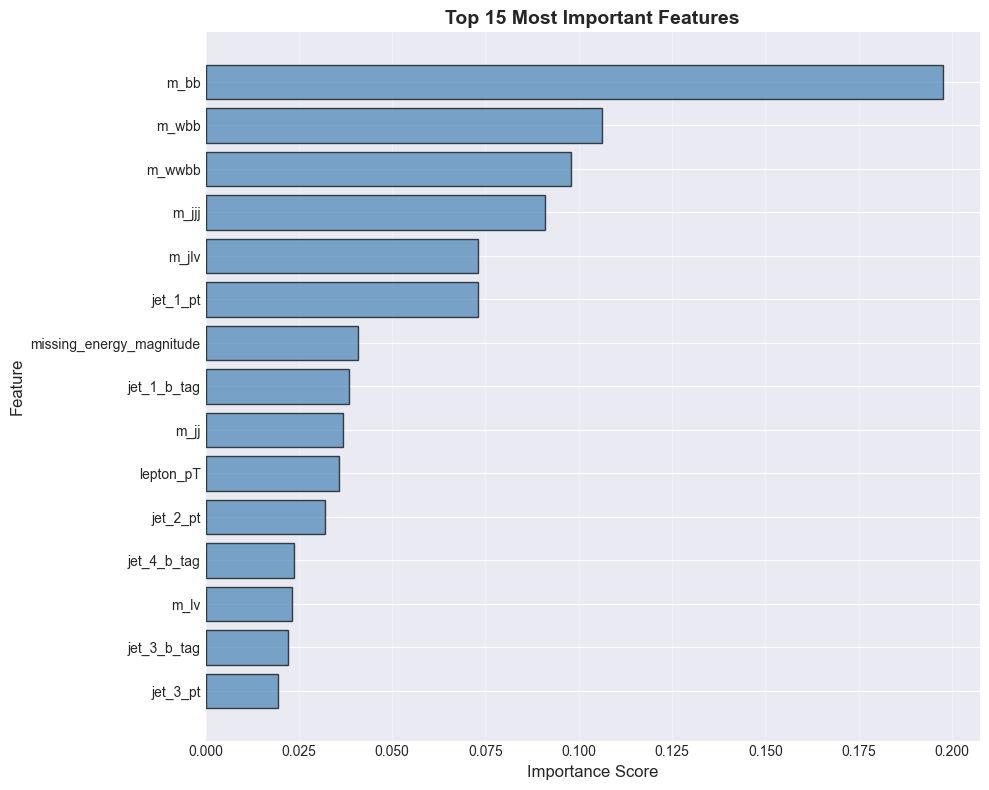

Logistic Regression Coefficient Magnitudes:
                     feature  importance
27                    m_wwbb      0.9980
26                     m_wbb      0.6454
25                      m_bb      0.6019
5                   jet_1_pt      0.3626
22                     m_jjj      0.2778
3   missing_energy_magnitude      0.2391
24                     m_jlv      0.1963
0                  lepton_pT      0.1772
21                      m_jj      0.1108
23                      m_lv      0.1078
17                  jet_4_pt      0.0946
9                   jet_2_pt      0.0903
16               jet_3_b_tag      0.0802
20               jet_4_b_tag      0.0766
13                  jet_3_pt      0.0672
Feature importance plot saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\baseline_lr_coefficients.png


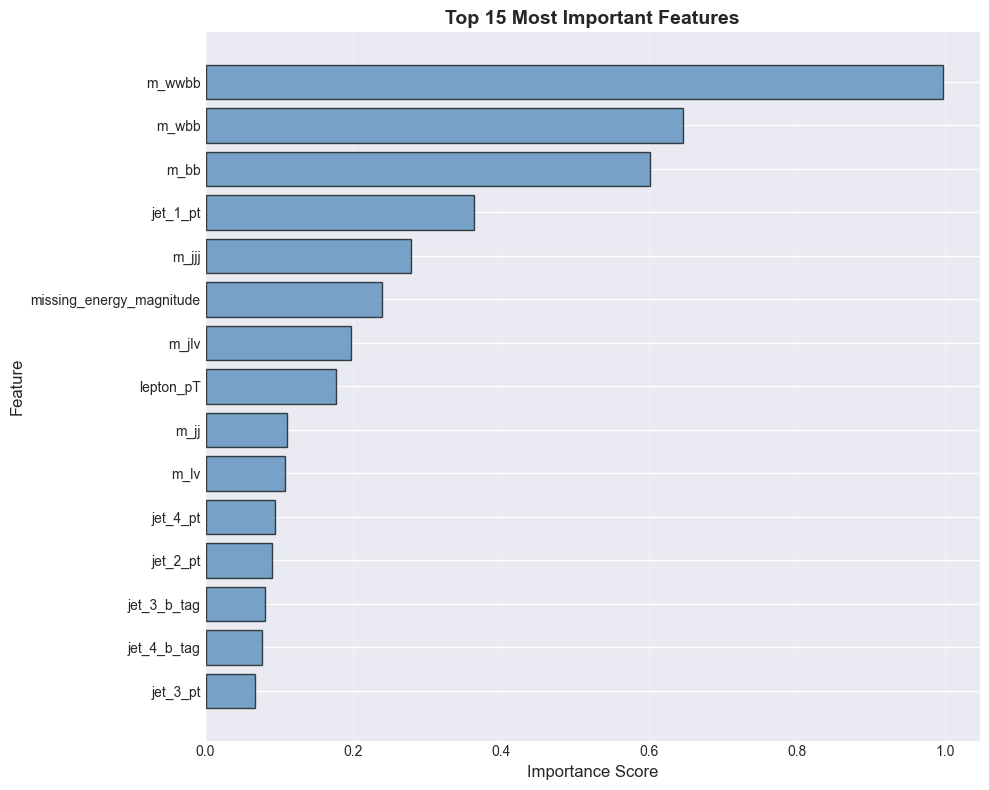


Feature importance analysis complete


In [16]:
# Cell 13: Extracting Feature Importance (Tree-based Models)
# Identifying most important features for classification
# Models: Random Forest and XGBoost (both have feature_importances_)

print("FEATURE IMPORTANCE ANALYSIS")

# Extracting feature importance from Random Forest
print("\nRandom Forest Feature Importance:")
rf_importance = extract_feature_importance(
    model=baseline_results['random_forest']['model'],
    feature_names=ALL_FEATURES,
    top_n=15
)
print(rf_importance)

# Plotting
plot_feature_importance_horizontal(
    importance_df=rf_importance,
    top_n=15,
    save_path=FIGURE_OUTPUT / 'baseline_rf_feature_importance.png'
)

# Extracting feature importance from XGBoost
print("XGBoost Feature Importance:")
xgb_importance = extract_feature_importance(
    model=baseline_results['xgboost']['model'],
    feature_names=ALL_FEATURES,
    top_n=15
)
print(xgb_importance)

# Plotting
plot_feature_importance_horizontal(
    importance_df=xgb_importance,
    top_n=15,
    save_path=FIGURE_OUTPUT / 'baseline_xgb_feature_importance.png'
)

# Extracting coefficients from Logistic Regression
print("Logistic Regression Coefficient Magnitudes:")
lr_importance = extract_feature_importance(
    model=baseline_results['logistic_regression']['model'],
    feature_names=ALL_FEATURES,
    top_n=15
)
print(lr_importance)

# Plotting
plot_feature_importance_horizontal(
    importance_df=lr_importance,
    top_n=15,
    save_path=FIGURE_OUTPUT / 'baseline_lr_coefficients.png'
)

print("\nFeature importance analysis complete")

In [19]:
# Cell 14: Create Performance Comparison Table
# Summarizing all metrics in single table for easy comparison

print("BASELINE PERFORMANCE COMPARISON")

# Creating metrics dictionary for table
metrics_for_table = {}
for model_name, results in baseline_results.items():
    metrics_for_table[model_name] = results['metrics']

# Creating comparison table
comparison_table = create_metrics_summary_table(metrics_for_table)

# Adding training time
training_times = {model_name: results['training_time'] 
                  for model_name, results in baseline_results.items()}
comparison_table['training_time'] = comparison_table['model'].map(training_times)

# Sorting by F1-score (primary metric for imbalanced data)
comparison_table = comparison_table.sort_values('f1_score', ascending=False)

# Key Performance Metrics:

print("\n" + "="*70)
print("TABLE 1: PRIMARY PERFORMANCE METRICS")
print("="*70)

# Selecting key columns for primary view
primary_metrics = comparison_table[[
    'model', 
    'accuracy', 
    'precision', 
    'recall', 
    'f1_score',
    'auc_roc',
    'auc_pr'
]].copy()

# Rounding for better readability
primary_metrics['accuracy'] = primary_metrics['accuracy'].round(4)
primary_metrics['precision'] = primary_metrics['precision'].round(4)
primary_metrics['recall'] = primary_metrics['recall'].round(4)
primary_metrics['f1_score'] = primary_metrics['f1_score'].round(4)
primary_metrics['auc_roc'] = primary_metrics['auc_roc'].round(4)
primary_metrics['auc_pr'] = primary_metrics['auc_pr'].round(4)

# Renaming columns for display
primary_metrics.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 
                           'F1-Score', 'AUC-ROC', 'AUC-PR']

print(primary_metrics.to_string(index=False))

# Additional Metrics:

print("\n" + "="*70)
print("TABLE 2: ADDITIONAL METRICS")
print("="*70)

additional_metrics = comparison_table[[
    'model',
    'g_mean',
    'mcc',
    'sensitivity',
    'specificity'
]].copy()

# Rounding
additional_metrics['g_mean'] = additional_metrics['g_mean'].round(4)
additional_metrics['mcc'] = additional_metrics['mcc'].round(4)
additional_metrics['sensitivity'] = additional_metrics['sensitivity'].round(4)
additional_metrics['specificity'] = additional_metrics['specificity'].round(4)

# Renaming columns
additional_metrics.columns = ['Model', 'G-Mean', 'MCC', 
                              'Sensitivity', 'Specificity']

print(additional_metrics.to_string(index=False))

# Confusion Matrix Components:

print("\n" + "="*70)
print("TABLE 3: CONFUSION MATRIX BREAKDOWN")
print("="*70)

confusion_metrics = comparison_table[[
    'model',
    'true_positives',
    'true_negatives',
    'false_positives',
    'false_negatives'
]].copy()

# Renaming columns
confusion_metrics.columns = ['Model', 'True Pos', 'True Neg', 
                             'False Pos', 'False Neg']

print(confusion_metrics.to_string(index=False))

# Training Time Analysis:

print("\n" + "="*70)
print("TABLE 4: COMPUTATIONAL EFFICIENCY")
print("="*70)

# Creating time analysis table
time_analysis = comparison_table[['model', 'training_time']].copy()

# Converting time to readable format
def format_time(seconds):
    if seconds < 60:
        return f"{seconds:.2f}s"
    else:
        minutes = int(seconds // 60)
        remaining_seconds = seconds % 60
        return f"{minutes}m {remaining_seconds:.1f}s"

time_analysis['time_formatted'] = time_analysis['training_time'].apply(format_time)

# Calculating relative speed
fastest_time = time_analysis['training_time'].min()
time_analysis['relative_speed'] = (time_analysis['training_time'] / fastest_time).round(2)

# Selecting display columns
time_display = time_analysis[['model', 'time_formatted', 'relative_speed']].copy()
time_display.columns = ['Model', 'Training Time', 'Relative Speed (vs Fastest)']

print(time_display.to_string(index=False))

# SUMMARY STATISTICS:

print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)

# Identifying best model
best_model = comparison_table.iloc[0]['model']
best_f1 = comparison_table.iloc[0]['f1_score']
best_auc = comparison_table.iloc[0]['auc_roc']

print(f"\nBest Performing Model:")
print(f"  Model Name:    {best_model.replace('_', ' ').title()}")
print(f"  F1-Score:      {best_f1:.4f}")
print(f"  AUC-ROC:       {best_auc:.4f}")
print(f"  Accuracy:      {comparison_table.iloc[0]['accuracy']:.4f}")

# Performance statistics
print(f"\nPerformance Range (F1-Score):")
print(f"  Best:          {comparison_table['f1_score'].max():.4f}")
print(f"  Worst:         {comparison_table['f1_score'].min():.4f}")
print(f"  Range:         {comparison_table['f1_score'].max() - comparison_table['f1_score'].min():.4f}")
print(f"  Mean:          {comparison_table['f1_score'].mean():.4f}")
print(f"  Std Dev:       {comparison_table['f1_score'].std():.4f}")

# Training time statistics
print(f"\nTraining Time Range:")
print(f"  Fastest:       {format_time(comparison_table['training_time'].min())}")
print(f"  Slowest:       {format_time(comparison_table['training_time'].max())}")
print(f"  Total Time:    {format_time(comparison_table['training_time'].sum())}")

# Model rankings by different metrics
print(f"\nModel Rankings:")
print(f"  By F1-Score:   {comparison_table.iloc[0]['model']} > {comparison_table.iloc[1]['model']} > {comparison_table.iloc[2]['model']}")
print(f"  By AUC-ROC:    {comparison_table.sort_values('auc_roc', ascending=False).iloc[0]['model']} (Best)")
print(f"  By Speed:      {comparison_table.sort_values('training_time').iloc[0]['model']} (Fastest)")

BASELINE PERFORMANCE COMPARISON

TABLE 1: PRIMARY PERFORMANCE METRICS
              Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC  AUC-PR
                mlp    0.7546     0.7644  0.7758    0.7701   0.8378  0.8506
      random_forest    0.7318     0.7420  0.7568    0.7493   0.8130  0.8286
            xgboost    0.7303     0.7428  0.7509    0.7468   0.8109  0.8264
logistic_regression    0.6414     0.6390  0.7425    0.6869   0.6850  0.6832
                svm    0.5343     0.6010  0.3596    0.4500   0.5767  0.5906

TABLE 2: ADDITIONAL METRICS
              Model  G-Mean    MCC  Sensitivity  Specificity
                mlp  0.7529 0.5070       0.7758       0.7307
      random_forest  0.7297 0.4611       0.7568       0.7036
            xgboost  0.7287 0.4584       0.7509       0.7071
logistic_regression  0.6259 0.2771       0.7425       0.5275
                svm  0.5127 0.0973       0.3596       0.7311

TABLE 3: CONFUSION MATRIX BREAKDOWN
              Model  True Pos  True Neg  F

In [20]:
# Cell 15: Analyzing Performance Gaps
# Understanding which classes are misclassified

print("PER-CLASS PERFORMANCE ANALYSIS")

for model_name, results in baseline_results.items():
    print(f"\n{model_name.replace('_', ' ').title()}:")
    
    # Generating classification report
    from sklearn.metrics import classification_report
    report = classification_report(
        y_test,
        results['predictions'],
        target_names=['Background (0)', 'Signal (1)'],
        digits=4
    )
    print(report)
    
    # Analyzing errors
    metrics = results['metrics']
    print(f"  Sensitivity (Recall for Signal): {metrics['sensitivity']:.4f}")
    print(f"  Specificity (Recall for Background): {metrics['specificity']:.4f}")
    print(f"  False Positive Rate: {metrics['false_positives'] / (metrics['false_positives'] + metrics['true_negatives']):.4f}")
    print(f"  False Negative Rate: {metrics['false_negatives'] / (metrics['false_negatives'] + metrics['true_positives']):.4f}")

PER-CLASS PERFORMANCE ANALYSIS

Logistic Regression:
                precision    recall  f1-score   support

Background (0)     0.6453    0.5275    0.5805     94065
    Signal (1)     0.6390    0.7425    0.6869    105935

      accuracy                         0.6414    200000
     macro avg     0.6422    0.6350    0.6337    200000
  weighted avg     0.6420    0.6414    0.6369    200000

  Sensitivity (Recall for Signal): 0.7425
  Specificity (Recall for Background): 0.5275
  False Positive Rate: 0.4725
  False Negative Rate: 0.2575

Random Forest:
                precision    recall  f1-score   support

Background (0)     0.7198    0.7036    0.7116     94065
    Signal (1)     0.7420    0.7568    0.7493    105935

      accuracy                         0.7318    200000
     macro avg     0.7309    0.7302    0.7305    200000
  weighted avg     0.7316    0.7318    0.7316    200000

  Sensitivity (Recall for Signal): 0.7568
  Specificity (Recall for Background): 0.7036
  False Positive 

In [21]:
# Cell 16: Cross-Validation Stability Analysis
# Checking which models are most stable/consistent

print("MODEL STABILITY ANALYSIS (Cross-Validation)")

stability_data = []

for model_name, results in baseline_results.items():
    cv_results = results['cv_results']
    
    row = {'model': model_name}
    
    # Computing stability metrics for each scoring metric
    for metric in cv_metrics:
        test_key = f'test_{metric}'
        if test_key in cv_results:
            scores = cv_results[test_key]
            mean_score = scores.mean()
            std_score = scores.std()
            cv_coeff = (std_score / mean_score) * 100 if mean_score > 0 else 0
            
            row[f'{metric}_mean'] = mean_score
            row[f'{metric}_std'] = std_score
            row[f'{metric}_cv'] = cv_coeff
    
    stability_data.append(row)

# Creating stability DataFrame
stability_df = pd.DataFrame(stability_data)

print("\nCross-Validation Stability (Standard Deviations):")
print(stability_df[['model', 'f1_std', 'accuracy_std', 'roc_auc_std']].to_string(index=False))

print("\nCoefficient of Variation (lower is more stable):")
print(stability_df[['model', 'f1_cv', 'accuracy_cv', 'roc_auc_cv']].to_string(index=False))

# Identifying most stable model
most_stable = stability_df.loc[stability_df['f1_cv'].idxmin(), 'model']
print(f"\nMost Stable Model (lowest CV for F1): {most_stable}")

MODEL STABILITY ANALYSIS (Cross-Validation)

Cross-Validation Stability (Standard Deviations):
              model  f1_std  accuracy_std  roc_auc_std
logistic_regression  0.0004        0.0006       0.0010
      random_forest  0.0012        0.0012       0.0013
            xgboost  0.0009        0.0010       0.0011
                svm  0.0631        0.0111       0.0116
                mlp  0.0032        0.0017       0.0015

Coefficient of Variation (lower is more stable):
              model   f1_cv  accuracy_cv  roc_auc_cv
logistic_regression  0.0653       0.0922      0.1456
      random_forest  0.1602       0.1576      0.1577
            xgboost  0.1239       0.1372      0.1371
                svm 11.9983       2.0294      1.9980
                mlp  0.4210       0.2212      0.1791

Most Stable Model (lowest CV for F1): logistic_regression


COMPUTATIONAL EFFICIENCY ANALYSIS

Training Time Comparison:
              model  training_time_seconds  samples_per_second
Logistic Regression                 3.3449         239169.1669
            Xgboost                 4.3295         184780.1877
      Random Forest                72.4497          11042.1436
                Mlp               301.2740           2655.3898
                Svm              1254.2883            637.8119

Training time plot saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\baseline_training_times.png


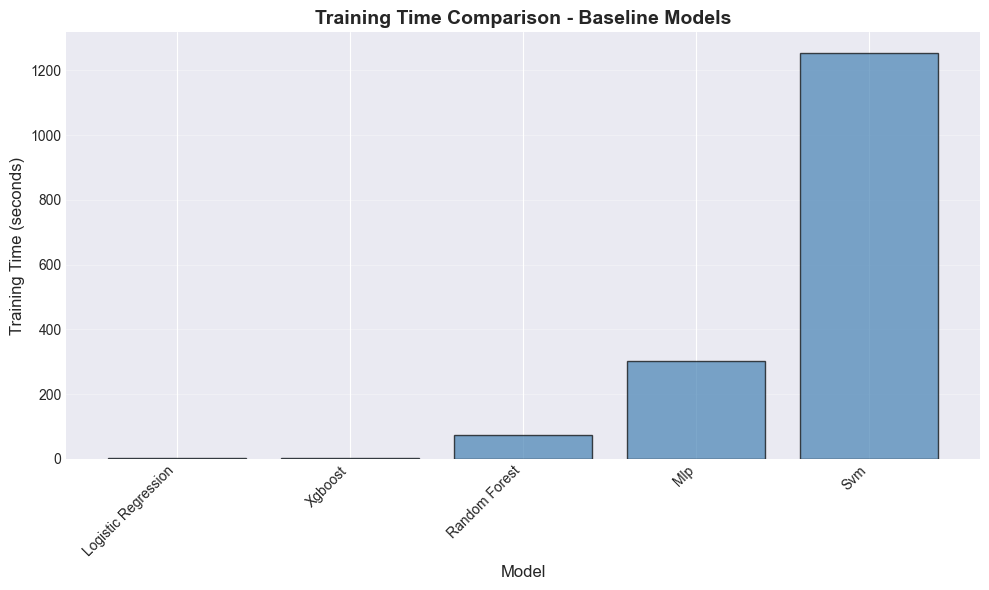


Fastest Model: Logistic Regression
Slowest Model: Svm


In [22]:
# Cell 17: Training Time Analysis
# Comparing computational efficiency of models

print("COMPUTATIONAL EFFICIENCY ANALYSIS")

# Creating training time summary
time_data = []
for model_name, results in baseline_results.items():
    time_data.append({
        'model': model_name.replace('_', ' ').title(),
        'training_time_seconds': results['training_time'],
        'samples_per_second': len(X_train) / results['training_time']
    })

time_df = pd.DataFrame(time_data).sort_values('training_time_seconds')

print("\nTraining Time Comparison:")
print(time_df.to_string(index=False))

# Visualizing training times
plt.figure(figsize=(10, 6))
plt.bar(time_df['model'], time_df['training_time_seconds'], 
        color='steelblue', alpha=0.7, edgecolor='black')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Training Time (seconds)', fontsize=12)
plt.title('Training Time Comparison - Baseline Models', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Saving
time_path = FIGURE_OUTPUT / 'baseline_training_times.png'
plt.savefig(time_path, dpi=DPI_VALUE, bbox_inches='tight')
print(f"\nTraining time plot saved to {time_path}")

plt.show()

fastest_model = time_df.iloc[0]['model']
slowest_model = time_df.iloc[-1]['model']
print(f"\nFastest Model: {fastest_model}")
print(f"Slowest Model: {slowest_model}")